##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved.

The dataset is downloaded from the public docket at:
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [34]:
!pip install torch

In [35]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [36]:
orig_df = pd.read_csv('/content/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [37]:
df = pd.read_csv('/content/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [38]:
df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [39]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [40]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means.
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data?


In [41]:
print(df.head())

            X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
0 -115.087518  36.216702             0                 0          0     0   
1 -115.240172  36.189693             1                 1          1     1   
2 -115.143088  36.181329             2                 1          2     0   
3 -115.225014  36.117633             3                 1          1     2   
4 -115.176708  36.095967             4                 1          1     3   

   VictimCount  
0            0  
1            0  
2            1  
3            2  
4            0  


**X**: coordinates of the incident location

**Y**: coordinates of the incident location

**Area_Command**: The command area where the incident occurred

**DayOfWeek**: Day of the week on which the incident reported

**Time**: Time when the incident was reported

**NIBRSOffenseCode**: Type of criminal offense

**VictimCount**: Number of people involved in the incident

Area_Command, DayOfWeek, Time, NIBRSOffenseCode, VictimCount are factorized such that the data in these columns now represent the data in numbers.

`inputs` are *X*, *Y*, *Area_Command*, *DayOfWeek*, *Time*, *NIBRSOffenseCode*.

`Target variable` is *VictimCount*

These columns need **no** scaling,shifting or normalizing the data as they are preprocessed.

## Task 2

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data.

In [42]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Prepare the input (X) and output (Y) variables
X = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']]
Y = df['VictimCount']

# Convert the Pandas DataFrames to PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
Y = torch.tensor(Y.values, dtype=torch.float32)

# Define a reasonable batch size (e.g., 64)
batch_size = 64

# Create a TensorDataset for the data
dataset = TensorDataset(X, Y)

# Split the dataset into training and testing sets (e.g., 80% for training, 20% for testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoader objects for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify the shape of data by iterating over the training dataset and printing the shape of a batched data
for batch_X, batch_Y in train_loader:
    print("Batch X shape:", batch_X.shape)
    print("Batch Y shape:", batch_Y.shape)
    break


Batch X shape: torch.Size([64, 6])
Batch Y shape: torch.Size([64])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem.

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the loss function for regression (Mean Squared Error)
loss_function = nn.MSELoss()

# Define the input size based on your dataset
input_size = 6

# Define the neural network architecture for regression
class CustomCrimeRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(CustomCrimeRegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Create an instance of the regression model
model = CustomCrimeRegressionModel(input_size)

# Define the optimizer (e.g., Adam) with a proper learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the number of training epochs
num_epochs = 50

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = loss_function(predictions, batch_Y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for batch_X, batch_Y in test_loader:
            predictions = model(batch_X)
            loss = loss_function(predictions, batch_Y)
            test_loss += loss.item()

    test_loss /= len(test_loader)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, MSE error for test: {test_loss:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch [1/50] - Train Loss: 3.1277, MSE error for test: 2.6456
Epoch [2/50] - Train Loss: 1.8972, MSE error for test: 1.6337
Epoch [3/50] - Train Loss: 1.5195, MSE error for test: 1.5618
Epoch [4/50] - Train Loss: 1.0925, MSE error for test: 1.3117
Epoch [5/50] - Train Loss: 1.2101, MSE error for test: 1.1623
Epoch [6/50] - Train Loss: 1.0919, MSE error for test: 1.4217
Epoch [7/50] - Train Loss: 1.0530, MSE error for test: 1.1506
Epoch [8/50] - Train Loss: 0.9834, MSE error for test: 1.1634
Epoch [9/50] - Train Loss: 0.9493, MSE error for test: 1.1873
Epoch [10/50] - Train Loss: 0.9294, MSE error for test: 1.1936
Epoch [11/50] - Train Loss: 0.9118, MSE error for test: 1.1362
Epoch [12/50] - Train Loss: 0.9053, MSE error for test: 1.1450
Epoch [13/50] - Train Loss: 1.1650, MSE error for test: 1.2008
Epoch [14/50] - Train Loss: 0.9177, MSE error for test: 1.1462
Epoch [15/50] - Train Loss: 0.9418, MSE error for test: 1.1881
Epoch [16/50] - Train Loss: 0.9703, MSE error for test: 1.1751
E

## Task 4

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem.

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

**Number of Classes:**
To determine the number of classes for the classification problem, you can look at the unique values in the 'VictimCount' column in your dataset. In your given data, you mentioned that 'VictimCount' has a maximum value of 15. This means you have 16 different classes (0 to 15) to predict.

**Architecture Differences:**
For a classification task, you should use a neural network architecture designed for classification. You can use a model with a final layer that has as many output units as there are classes (16 in this case) and use an appropriate activation function like Softmax to convert the network's output into class probabilities.

**Loss Function Differences:**
In classification problems, you typically use a different loss function, such as Cross-Entropy (also known as Negative Log-Likelihood) loss. This loss function measures the dissimilarity between the predicted class probabilities and the true class labels.

**Accuracy Calculation:**
To calculate accuracy on the test data, you need to compare the model's predicted class labels to the true class labels and calculate the proportion of correct predictions. This can be done at the end of each epoch.

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the loss function for classification (Cross-Entropy Loss)
loss_function = nn.CrossEntropyLoss()

# Define the input size, number of classes, and other hyperparameters
input_size = 6
num_classes = 16

# Define the neural network architecture for classification
class CustomCrimeClassificationModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CustomCrimeClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Create an instance of the classification model
model = CustomCrimeClassificationModel(input_size, num_classes)

# Define the optimizer (e.g., Adam) with a proper learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the number of training epochs
num_epochs = 50

# Training and evaluation loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0

    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)

        batch_Y = batch_Y.to(torch.long)

        loss = loss_function(predictions, batch_Y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, predicted = torch.max(predictions, 1)
        correct_train += (predicted == batch_Y).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = correct_train / len(train_loader.dataset)

    model.eval()
    test_loss = 0.0
    correct_test = 0

    with torch.no_grad():
        for batch_X, batch_Y in test_loader:
            predictions = model(batch_X)

            batch_Y = batch_Y.to(torch.long)

            loss = loss_function(predictions, batch_Y)
            test_loss += loss.item()

            _, predicted = torch.max(predictions, 1)
            correct_test += (predicted == batch_Y).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = correct_test / len(test_loader.dataset)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch [1/50] - Train Loss: 10.9662, Train Accuracy: 0.0045, Test Loss: 7.5970, Test Accuracy: 0.0000
Epoch [2/50] - Train Loss: 6.0142, Train Accuracy: 0.0045, Test Loss: 3.2143, Test Accuracy: 0.0000
Epoch [3/50] - Train Loss: 2.2701, Train Accuracy: 0.1455, Test Loss: 1.4037, Test Accuracy: 0.3455
Epoch [4/50] - Train Loss: 1.2236, Train Accuracy: 0.5227, Test Loss: 1.8422, Test Accuracy: 0.4364
Epoch [5/50] - Train Loss: 1.4077, Train Accuracy: 0.5364, Test Loss: 1.7286, Test Accuracy: 0.4364
Epoch [6/50] - Train Loss: 1.3538, Train Accuracy: 0.5773, Test Loss: 1.6318, Test Accuracy: 0.4545
Epoch [7/50] - Train Loss: 1.4080, Train Accuracy: 0.3636, Test Loss: 1.5678, Test Accuracy: 0.4182
Epoch [8/50] - Train Loss: 1.2495, Train Accuracy: 0.4864, Test Loss: 1.5702, Test Accuracy: 0.4364
Epoch [9/50] - Train Loss: 1.2152, Train Accuracy: 0.5364, Test Loss: 1.5199, Test Accuracy: 0.4364
Epoch [10/50] - Train Loss: 1.1345, Train Accuracy: 0.5364, Test Loss: 1.4373, Test Accuracy: 0.381

In [45]:
import numpy as np
from sklearn.model_selection import train_test_split

learning_rates = [0.001, 0.01, 0.1]
hidden_layer_dimensions = [(64, 32), (128, 64), (256, 128)]

best_accuracy = 0.0
best_model = None

for lr in learning_rates:
    for hidden_dim in hidden_layer_dimensions:
        class NeuralNetworkC(nn.Module):
            def __init__(self, input_size, num_classes):
                super(NeuralNetworkC, self).__init__()
                self.fc1 = nn.Linear(input_size, hidden_dim[0])
                self.relu = nn.ReLU()
                self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
                self.fc3 = nn.Linear(hidden_dim[1], num_classes)

            def forward(self, x):
                x = self.fc1(x)
                x = self.relu(x)
                x = self.fc2(x)
                x = self.relu(x)
                x = self.fc3(x)
                return x

        model = NeuralNetworkC(input_size, num_classes)
        loss_function = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        num_epochs = 50

        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0
            correct_train = 0

            for batch_X, batch_Y in train_loader:
                optimizer.zero_grad()
                predictions = model(batch_X)

                batch_Y = batch_Y.to(torch.long)

                loss = loss_function(predictions, batch_Y)
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(predictions, 1)
                correct_train += (predicted == batch_Y).sum().item()

            train_loss /= len(train_loader)
            train_accuracy = correct_train / len(train_loader.dataset)

            model.eval()
            test_loss = 0.0
            correct_test = 0

            with torch.no_grad():
                for batch_X, batch_Y in test_loader:
                    predictions = model(batch_X)
                    batch_Y = batch_Y.to(torch.long)

                    loss = loss_function(predictions, batch_Y)
                    test_loss += loss.item()

                    _, predicted = torch.max(predictions, 1)
                    correct_test += (predicted == batch_Y).sum().item()

            test_loss /= len(test_loader)
            test_accuracy = correct_test / len(test_loader.dataset)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = model

print(f"Best Test Accuracy: {best_accuracy:.4f}")


Best Test Accuracy: 0.4364


## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

We've addressed two distinct machine learning challenges: regression and classification, both with the objective of forecasting the number of crime victims. Regression revolves around predicting a continuous numeric outcome, while classification entails classifying data into distinct categories. I've supplied code and guidance for both tasks. The choice between these approaches hinges on the specific objectives and criteria for success.

Regression is well-suited for scenarios where the aim is to predict precise numerical values, and its performance can be assessed using metrics such as Mean Squared Error (MSE). In contrast, classification is designed for tasks involving the allocation of data into predefined classes, with accuracy and other classification metrics serving as common measures of performance. The selection between regression and classification hinges on the nature of the problem and the analytical objectives. If the primary goal is to forecast the exact count of crime victims, regression is typically the more appropriate choice. However, if the objective is to categorize crime incidents into severity classes (e.g., low, medium, high), classification becomes the preferred approach.

Misclassified Example True Label: 1.0


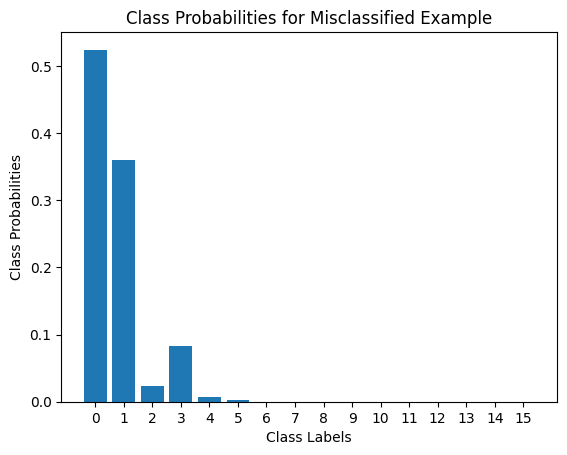

In [46]:
model.eval()

misclassified_examples = []
true_labels = []

for batch_X, batch_Y in test_loader:
    predictions = model(batch_X)
    predicted_labels = torch.argmax(predictions, dim=1)

    misclassified_indices = (predicted_labels != batch_Y).nonzero()

    if misclassified_indices.numel() > 0:
        misclassified_examples.extend(batch_X[misclassified_indices])
        true_labels.extend(batch_Y[misclassified_indices])
        break

if len(misclassified_examples) > 0:
    misclassified_example = misclassified_examples[0]
    true_label = true_labels[0]

    print(f'Misclassified Example True Label: {true_label.item()}')

    probabilities = torch.softmax(predictions[0], dim=0).tolist()
    class_labels = list(range(num_classes))

    plt.bar(class_labels, probabilities, tick_label=class_labels)
    plt.xlabel('Class Labels')
    plt.ylabel('Class Probabilities')
    plt.title('Class Probabilities for Misclassified Example')
    plt.show()
else:
    print("No misclassified examples found in the test data.")


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


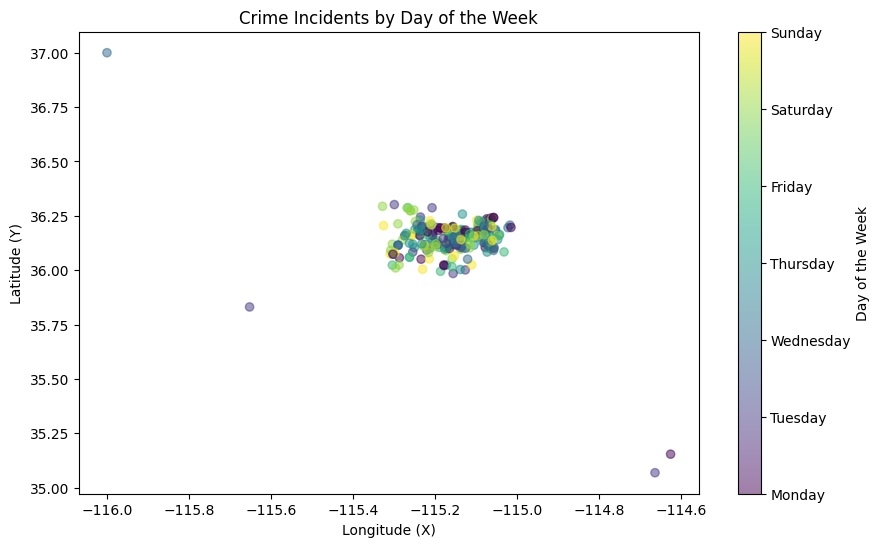

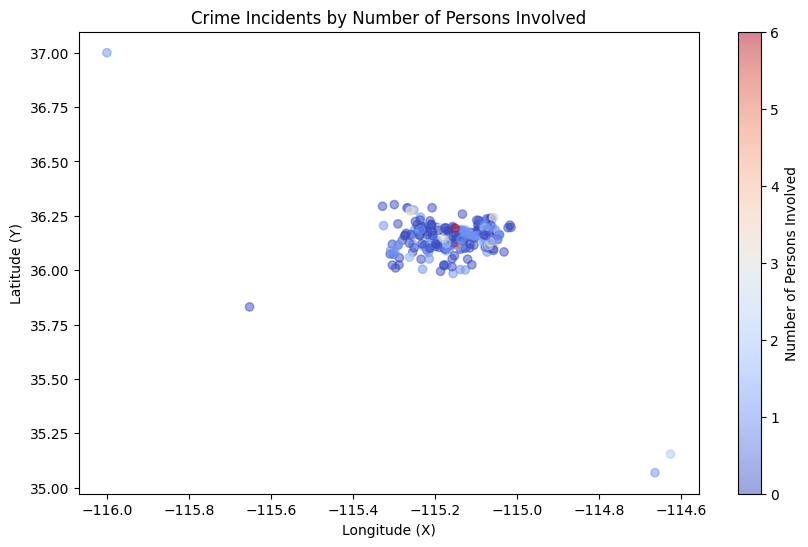

Most frequent day for reported crimes: Friday


In [53]:
from matplotlib import ticker

crime_counts_by_day = df['DayOfWeek'].value_counts().sort_index()

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))
colors = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
scatter = plt.scatter(df['X'], df['Y'], c=df['DayOfWeek'], cmap='viridis', alpha=0.5)
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.title('Crime Incidents by Day of the Week')
plt.colorbar(scatter, label='Day of the Week', ticks=range(7), format=ticker.FuncFormatter(lambda x, pos: colors[int(x)]))
plt.show()

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='coolwarm', alpha=0.5)
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.title('Crime Incidents by Number of Persons Involved')
plt.colorbar(scatter, label='Number of Persons Involved')
plt.show()

most_frequent_day = day_names[crime_counts_by_day.idxmax()]
print(f"Most frequent day for reported crimes: {most_frequent_day}")
